In [1]:
import obspy, glob
import numpy as np
import pandas as pd
import numpy.matlib
from obspy import Trace, UTCDateTime, Stream
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from scipy import signal, ndimage
from scipy.io.wavfile import read, write
import cv2
import dask
import dask_image.ndfilters
import dask.array
from datetime import datetime, date, timedelta
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/Volumes/Data/Soundscape/02_KeeLung/2023/20230609-20230625/wav/'

S = -176.2 # end to end 
P_ref = 1 # water: 1 uPa
interval = 10 # sec
fmin = 100 # Hz
fmax = 1000 # Hz

# local_cluster = LocalCluster(n_workers=2, processes=False, threads_per_worker=16)

In [40]:
def calib(data, S):
    audio_data = data.astype(np.float32, order='C') / 32768.0
    calib_data = audio_data / ((10)**(S/20))
    return calib_data # uPa

          
def spectrogram(data, sampling_frequency, window='hann', fmin=200, fmax=1000):
    
    f, t, spect = signal.spectrogram(
                    data,
                    fs=sampling_frequency,
                    window=window,
                    nperseg=int(sampling_frequency/20),
                    noverlap=int(sampling_frequency/20*0.9),
                    nfft=2**16,
                    scaling="spectrum" )
    
    fmin_idx = np.where(f <= fmin)[0][-1]+1
    fmax_idx = np.where(f <= fmax)[0][-1]-1
    f = f[fmin_idx:fmax_idx]
    spect = spect[fmin_idx:fmax_idx, :]
    return f, t, spect

def denoise(spect, duration=3, time_resolution=0.01, use_dask=True):
    if use_dask:
        
        dask_spectro = dask.array.from_array(spect, chunks=[1000,1000])
        Smed = dask_image.ndfilters.percentile_filter(
            dask_spectro, 50,
            size=(1, round(duration / time_resolution)),
            mode="mirror",
        )
        Smed = Smed.compute()
    else:
        
        Smed = ndimage.percentile_filter(
                spect, 50,
                (1, round(duration / time_resolution)) ) 
    
    spect = spect - Smed
    spect[spect < 0] = 0  # floor
    
    return spect
def detect(t, f, spect, tr, starttime, kernel_duration=0.05, kernel_bandwidth=300, threshold_pct=90, f_noise=None, use_dask=False):
    f_res = f[1]-f[0]
    t_res = round(t[1]-t[0], 5)
    kernel_duration = max(round(kernel_duration/t_res), 1) #sec to pt
    kernel_bandwidth = max(round(kernel_bandwidth/f_res), 1) #Hz to pt
    if use_dask:
        dask_spectro = dask.array.from_array(spect, chunks=[1000,1000])
        Svar = dask_image.ndfilters.generic_filter(dask_spectro,
                                                   calcVariance2D,
                                                   size=(kernel_bandwidth, kernel_duration),
                                                   mode='mirror')
        Svar = Svar.compute()
    else:
        imx = np.zeros(spect.shape)
        Svar = ndimage.generic_filter(spect,
                                  calcVariance2D,
                                  (kernel_bandwidth, kernel_duration),
                                  mode='mirror')
        # Svar = ndimage.gaussian_filter(Svar, sigma=2, mode = 'mirror')
        # Svar = ndimage.generic_filter(spect,
        #                           calcVariance2D,
        #                           (kernel_bandwidth, kernel_duration),
        #                           mode='mirror')
    # binarization
    threshold = np.percentile(Svar, threshold_pct, interpolation='linear')
    Svar[Svar < threshold] = 0
    Svar[Svar > 0] = 1
    
    Svar_gray = cv2.normalize(src=Svar,
                              dst=None,
                              alpha=0,
                              beta=255,
                              norm_type=cv2.NORM_MINMAX,
                              dtype=cv2.CV_8UC1)
    (cnts, hierarchy) = cv2.findContours(Svar_gray.copy(),
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_SIMPLE)   
    cnts_sorted = sorted(list(cnts),key=lambda d: d[0][0][0])
    # loop over the contours
    isdetec = False
    t1 = []; t2 = []
    fmin = []; fmax = []
    
    for ii, c in enumerate(cnts_sorted):
        # Compute the bounding box for the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # if the contour is too small, ignore it
        if w < kernel_duration or h < kernel_bandwidth:
            continue
        elif h >= round((f[-1]-f[0])/f_res, 2)*0.8: ## avoid broadband-noise
            print('broadband-noise')
            continue
        elif f_noise is not None:
            peak_f_detect = Peak_frequency(f, spect[y:y+h-1, x:x+w-1]) 
            if abs(peak_f_detect-f_noise) > 20 :
                print(ii, peak_f_detect, 'V')
                t1.append(x); t2.append(x+w-1) 
                fmin.append(y); fmax.append(y+h-1) 
            else:
                print(ii, peak_f_detect, 'X')
        else:
            isdetec = True

            if len(t1)>0 and t2[-1]>=x>=t1[-1]:    ## avoid repeated detection
                _fmin = fmin[-1]; _fmax = fmax[-1]
                if y<_fmin :
                    fmin[-1] = y
                if (y+h-1)>_fmax:
                    fmax[-1] = y+h-1
                continue
            else:
                t1.append(x); t2.append(x+w-1) # box coord
                fmin.append(y); fmax.append(y+h-1)   
    
    detec = {} 
    detec['time_min_offset'] = [t[0]+_t*t_res for _t in t1]
    detec['time_max_offset'] = [t[0]+_t*t_res for _t in t2]
    detec['frequency_min'] = [f[_f] for _f in fmin]
    detec['frequency_max'] = [f[_f] for _f in fmax]
    detec['duration'] = np.array(detec['time_max_offset']) - np.array(detec['time_min_offset'])
    detec['time_min_date'] = [starttime+_t*t_res+t[0] for _t in t1] 
    detec['time_max_date'] = [starttime+_t*t_res+t[0] for _t in t2]
    detec['SPLpp'] = [ SPL_PP(tr, t1, t2) for t1, t2 in zip(detec['time_min_date'], detec['time_max_date'])]
    detec = pd.DataFrame(detec)
    detec.sort_values('time_min_offset',
                       ascending=True,
                       inplace=True,
                       ignore_index=True )
    return Svar, detec, cnts_sorted

def calcVariance2D(buffer):
    """Calculate the 2D variance."""
    return np.var(buffer)
    # return np.median(buffer.ravel())
    # return np.mean(buffer.ravel())
    
def plot_annot(detectfile, ax, type='spectrogram'):
    if type == 'spectrogram':
        alpha = 0.7
        facecolor = "none"
        color='red'
        label='detected'
        line_width = 0.7
        for index, row in detectfile.iterrows():
            x = row["time_min_offset"]
            y = row["frequency_min"]
            width = row["duration"]
            height = row["frequency_max"] - row["frequency_min"]
            import matplotlib.patches as patches
            rect = patches.Rectangle((x, y), width, height, linewidth=line_width, edgecolor=color, facecolor=facecolor, alpha=alpha)
            ax.add_patch(rect)  
    elif type == 'waveform':
        alpha = 0.1
        facecolor = "red"
        color='none'
        label='detected'
        line_width = 0.5
        for index, row in detectfile.iterrows():
            x = row["time_min_offset"]
            y = min(ax.get_ylim())
            width = row["duration"]
            height = max(ax.get_ylim()) - min(ax.get_ylim())
            
            import matplotlib.patches as patches
            rect = patches.Rectangle((x, y), width, height, linewidth=line_width, edgecolor=color, facecolor=facecolor, alpha=alpha)
            ax.add_patch(rect)  
    return ax

def SPL_PP(tr, t1, t2):
    P_ref = 1
    tr_sound = tr.slice(t1, t2)
    p_peak = max(tr_sound.data)+abs(min(tr_sound.data))
    P_spl = 20*np.log10(p_peak/P_ref)
    return P_spl

def Peak_frequency(f, data):
    sum_energy = np.sum(data, axis=1)
    Emax_freq = f[np.argmax(sum_energy)]
    return Emax_freq

In [38]:
df_min = {'Time':[],
         'Peak': [],
         'MaxSPL': [], 
         'SPLrms':[]}
for file in glob.glob(f'{path}/????.23062422*.wav'):
    print(file)
    rate, data_ = read(file) 
    data = calib(data_, S)
    
    filetime = file.rsplit('.')[1]
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    if rate == 96000:
        tr.decimate(2, no_filter=True) 
    tr.stats.starttime = UTCDateTime(2023, int(filetime[2:4]), int(filetime[4:6]), int(filetime[6:8]), int(filetime[8:10]), int(filetime[10:]))
    tr_bp = tr.copy()
    tr_bp.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=6, zerophase=True)
#     total_min = int(tr.stats.endtime - tr.stats.starttime)/60
    

#     for mm in range(int(total_min)):

print('finished ')

/Volumes/Data/Soundscape/02_KeeLung/2023/20230609-20230625/wav/7080.230624220003.wav
finished 


In [15]:
# plt.figure(figsize=(12,3))
# plt.plot(tr_bp.times(), tr_bp.data, 'k', lw=1)
# plt.ylabel('Pressure ($\mu$Pa)')
# plt.xlim(2000, 2000.5)
# plt.ylim(-7*10**6,7*10**6)

## for plotting 

In [ ]:
alldetect = pd.DataFrame([])
plot = True


t0 = datetime.now()
total_sec = int(tr_bp.stats.endtime - tr_bp.stats.starttime)
for dt in np.arange(300, 400, 10):
    print(dt)
    tr_cut = tr_bp.copy() 
    start  = tr_bp.stats.starttime + dt 
    end    = start + 10 #interval
    tr_cut = tr_cut.slice(starttime=start, endtime=end)
    tr_cut.data = tr_cut.data - np.mean(tr_cut.data)

    print('--------------- Calculate spectro.')
    f, t, spect = spectrogram(tr_cut.data, tr_cut.stats.sampling_rate,  fmin=fmin, fmax=fmax)
    
    print('--------------- Calculate detection.  ')
    spect_denoise = denoise(spect)
    
    Emax_freq = Peak_frequency(f, spect_denoise)
    freq_noise = Emax_freq if Emax_freq < 200 else None
    if freq_noise is not None:
        print(f'--------------- {Emax_freq}')
    Svar_, detec, cnts_sorted = detect(t, f, spect_denoise, tr_cut, starttime=tr_cut.stats.starttime, use_dask=True, \
                                       threshold_pct=90, f_noise=freq_noise, kernel_duration=0.05, kernel_bandwidth=300)
    alldetect = pd.concat([alldetect, detec])
    if plot:
        fig, ax = plt.subplots(3, 1 ,figsize=(7, 5), sharex=True)
        plt.rc('font', family='Helvetica')
        ax[0].plot(tr_cut.times(), tr_cut.data, 'k')
        ax[0].set_xlim(tr_cut.times()[0], tr_cut.times()[-1])
        ax[0].set_ylabel('Pressure ($\mu$Pa)')
        

        ax[1].pcolormesh(t, f, spect_denoise, cmap="Blues",
                        vmin=np.percentile(spect_denoise, 90),
                        vmax=np.percentile(spect_denoise, 99.9),
                        shading="gouraud")
        ax[1].set_ylim(fmin, fmax)
        ax[1].set_ylabel('Frequency (Hz)')

        ax[2].pcolormesh(t, f, Svar_, cmap="binary")
        ax[2].set_ylim(fmin, fmax)
        ax[2].set_xlabel('Time (s)')
        ax[2].set_ylabel('Frequency (Hz)')

        print('--------------- Plot annot. ')
        ax[1] = plot_annot(detec, ax[1], type='spectrogram')
        ax[0] = plot_annot(detec, ax[0], type='waveform')
        if freq_noise is None:
            title = f'# of detection: {len(detec)}\n{tr_cut.stats.starttime}'
        else:
            title = f'# of detection: {len(detec)}; Peak frequency: {int(Emax_freq)}Hz\n{tr_cut.stats.starttime}'
        ax[0].set_title(title)
        

        
t1 = datetime.now()
print(f'calculating time {t1-t0}')
# fig.savefig('Example2.png', dpi = 200)

300
--------------- Calculate spectro.
--------------- Calculate detection.  
--------------- Plot annot. 
310
--------------- Calculate spectro.
--------------- Calculate detection.  
--------------- Plot annot. 
320
--------------- Calculate spectro.
--------------- Calculate detection.  
--------------- Plot annot. 
330
--------------- Calculate spectro.
--------------- Calculate detection.  
--------------- Plot annot. 
340
--------------- Calculate spectro.
--------------- Calculate detection.  
--------------- Plot annot. 
350
--------------- Calculate spectro.
--------------- Calculate detection.  
--------------- Plot annot. 
360
--------------- Calculate spectro.
--------------- Calculate detection.  


Text(0.5, 1.0, '# of detection: 15\n2023-06-25T12:05:03.000000Z')

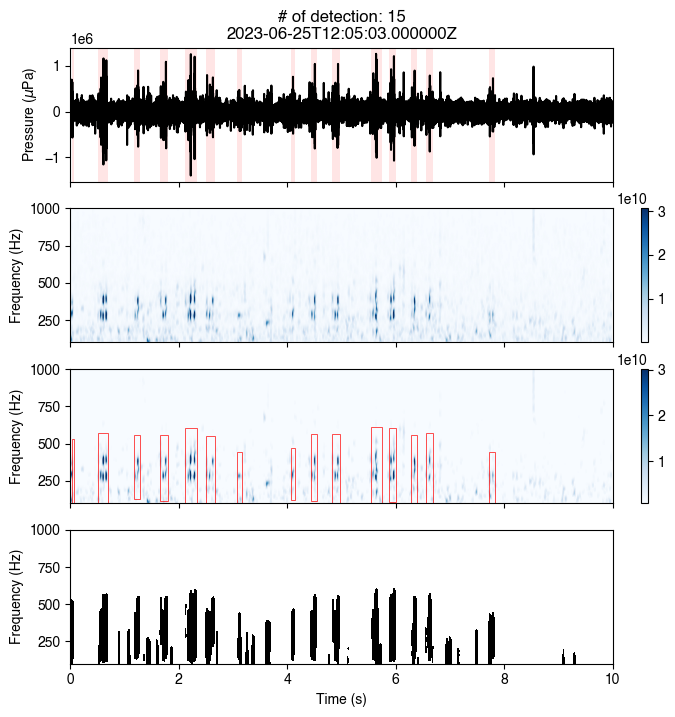

In [28]:
fig, ax = plt.subplots(4, 1 ,figsize=(7, 8), sharex=True)
plt.rc('font', family='Helvetica')
ax[0].plot(tr_cut.times(), tr_cut.data, 'k')
ax[0].set_xlim(tr_cut.times()[0], tr_cut.times()[-1])
ax[0].set_ylabel('Pressure ($\mu$Pa)')

axp = ax[1].pcolormesh(t, f, spect, cmap="Blues",
                vmin=np.percentile(spect, 1),
                vmax=np.percentile(spect, 99.9),
                shading="gouraud")
ax[1].set_ylim(fmin, fmax)
ax[1].set_ylabel('Frequency (Hz)')

pos1 = ax[1].get_position()
cax = plt.axes((pos1.x1+0.04, pos1.y0, 0.01, pos1.y1-pos1.y0))
plt.colorbar(axp, cax=cax)

# cb = plt.colorbar(axp ,ax = ax[1], location = 'left')

ax2 = ax[2].pcolormesh(t, f, spect_denoise, cmap="Blues",
                vmin=np.percentile(spect_denoise, 90),
                vmax=np.percentile(spect_denoise, 99.9),
                shading="gouraud")
ax[2].set_ylim(fmin, fmax)
ax[2].set_ylabel('Frequency (Hz)')
pos1 = ax[2].get_position()
cax = plt.axes((pos1.x1+0.04, pos1.y0, 0.01, pos1.y1-pos1.y0))
plt.colorbar(ax2, cax=cax)

ax[3].pcolormesh(t, f, Svar_, cmap="binary")
ax[3].set_ylim(fmin, fmax)
ax[3].set_xlabel('Time (s)')
ax[3].set_ylabel('Frequency (Hz)')


ax[2] = plot_annot(detec, ax[2], type='spectrogram')
ax[0] = plot_annot(detec, ax[0], type='waveform')

if freq_noise is None:
    title = f'# of detection: {len(detec)}\n{tr_cut.stats.starttime}'
else:
    title = f'# of detection: {len(detec)}; Peak frequency: {int(Emax_freq)}Hz\n{tr_cut.stats.starttime}'
ax[0].set_title(title)